## Import Packages

In [ ]:
# import packages
import json
import glob
import pandas as pd
# import pandasql as ps #SQL on Pandas Dataframe
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive
from sklearn.model_selection import train_test_split
from collections import Counter
import seaborn as sns

# Loading Data

We are using en.openfoodfacts.org.products.tsv file for this project from a Kaggle [dataset](https://www.kaggle.com/datasets/openfoodfacts/world-food-facts).

To get the data in here:
1. Go to this [Kaggle link](https://www.kaggle.com) and create a Kaggle account (unless you already have one)
2. Go to Account and click on "Create New API Token" to get the API key in the form of a json file `kaggle.json`
3. Upload the `kaggle.json` file to the default location in your Google Drive, 'MyDrive' (Please **DO NOT** upload the json file into any _specific_ folder).

Run the following cells to allow Colab to connect to Kaggle and to download the data used in this project.

In [ ]:
%%capture
!apt update
!pip install kaggle

In [ ]:
# Run this cell to mount your drive (you will be prompted to sign in)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Create the kaggle directory and
# (NOTE: Do NOT run this cell more than once unless restarting kernel)
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [ ]:
# Download dataset
!!kaggle datasets download -d openfoodfacts/world-food-facts

In [ ]:
# Unzip folder in Colab content folder
!unzip /content/world-food-facts.zip

Archive:  /content/world-food-facts.zip
replace en.openfoodfacts.org.products.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: en.openfoodfacts.org.products.tsv  


In [ ]:
raw_df = pd.read_csv("/content/en.openfoodfacts.org.products.tsv", sep="\t")

In [ ]:
raw_df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Wrangling


In [ ]:
# Original data shape
raw_df.shape

(356027, 163)

In [ ]:
#  This and next blogs are used to check each column and its elements
r_df = raw_df['no_nutriments'].dropna()
r_df.head(10)

In [ ]:
r_df.shape

**Dropping Unwanted Columns**

In [ ]:
drop_features = ['url', # no linking
                 'created_t',
                 'created_datetime',
                 'last_modified_t',
                 'last_modified_datetime',
                 'generic_name',
                 'quantity',
                 'packaging',
                 'packaging_tags', # i dont think we need this, many items are Nans but also i dont think this really matters as a feature
                 'brands',
                 'brands_tags',
                 #'categories', # I think  we might want this, it might be useful but we can reevaluate later
                 'manufacturing_places',
                 'manufacturing_places_tags',
                 'labels',
                 'labels_tags',
                 'first_packaging_code_geo',
                 'cities',
                 'cities_tags',
                 'purchase_places',
                 'stores',
                 'countries',
                 'countries_tags',
                 'countries_en',
                 'allergens', # allergens would be cool to explore in future efforts but for this question this does not help NUTRITIONAL VALUE
                 'allergens_en',
                 'traces',
                 'traces_tags',
                 'traces_en',
                 'no_nutriments',
                 'additives_tags',
                 'ingredients_from_palm_oil',
                 'ingredients_from_palm_oil_n',
                 'ingredients_from_palm_oil_tags',
                 'ingredients_that_may_be_from_palm_oil_n',
                 'ingredients_that_may_be_from_palm_oil',
                 'ingredients_that_may_be_from_palm_oil_tags',
                 'nutrition_grade_uk',
                 'pnns_groups_1',
                 'pnns_groups_2',
                 'states',
                 'states_tags',
                 'states_en',
                 'main_category',
                 'image_url',
                 'image_small_url',
                 'categories_tags']


In [ ]:
# Drop all columns that we don't intend to use for the project.
# origins(_tags) and emb_codes(_tags) are related to countries of origins of ingredients
# nutrition_grade_fr are related to grade level (abcde) of food
# serving_size for separating solid food (k/kg) and liquid (ml/l)
# additives_n: number of additives added to food;
# additives: other things added to food (suger, syrup...)
# additives_en: chemical things added to food
# main_category_en

df_cleaned = raw_df.drop(columns= drop_features)

**Acquiring English Data**

The data contains all kinds of languages and input sources. Since our goal is to compare the organic and non-organic food, we must be able to filter the organic food. Our method is finding key word 'organic' in product_name and ingredients_text columns.

The first obstacle for this method is the different languages of inputs. We tried to import googletrans library and translate the two columns' data after splitting and cleaning the elements in rows. However, the two columns' data contains so many unpredictable patterns and symbols that always interrupt the translation. Thus, we can not get the final translation result.

Another way we tried was to detect the English language inputs. After testing nltk.detect, langdetect.detect, we found it not reliable to separate English inputs from other languages such as French and Italian, since some French and Italian food's names are in their own words and mixed in English.

After exploration of the data, we decided to acquire data in English from two parts: one is USDA imported data and the other is non-usda-imported data that contain key word 'organic' in product_name and ingredients_text columns. For the USDA imported data, we can simply filter by looking for 'usda-ndb-import' in the creator column. The USDA data are in English and has reliable quality. For the other part of data, we can not translate the languages of the rest data, but we can certainly pick out the organic food data from it since the key word 'organic' only appear in English inputs.

In [ ]:
# USDA data number of rows
usda_df = raw_df['creator'].dropna()
usda_df = usda_df[usda_df.str.contains('usda')]
print('There are {} rows in the USDA imported data.'.format(usda_df.shape[0]))

There are 169868 rows in the USDA imported data.


In [ ]:
# Filter data to get the data in English inputs from two parts: USDA imported data and non-usda-imported data that contain key word 'organic' in product_name and ingredients_text columns.

# USDA label
df_cleaned['usda'] = df_cleaned['creator'].apply(lambda x: 1 if 'usda' in str(x) else 0)
# Label for Non-USDA 'organic' in product_name
df_cleaned['org_out_of_usda_n'] = df_cleaned[df_cleaned['usda']==0]['product_name'].apply(lambda x: 1 if 'organic' in str(x).lower() else 0)
# Label for Non-USDA 'organic' in ingredients_text
df_cleaned['org_out_of_usda_i'] = df_cleaned[df_cleaned['usda']==0]['ingredients_text'].apply(lambda x: 1 if 'organic' in str(x).lower() else 0)
# Combine Label of Non-USDA 'organic' in product_name and ingredients_text
df_cleaned['org_out_of_usda_combine'] = df_cleaned['org_out_of_usda_n'] + df_cleaned['org_out_of_usda_i']
df_cleaned['org_out_of_usda'] = df_cleaned['org_out_of_usda_combine'].apply(lambda x: 1 if x > 0 else 0)
# Combine Label of USDA and Non-USDA organic
df_cleaned['usda_and_org_out_of_usda'] = df_cleaned['org_out_of_usda'] + df_cleaned['usda']
df_cleaned = df_cleaned[df_cleaned['usda_and_org_out_of_usda'] > 0]
# Drop intermediant columns
df_cleaned.drop(columns=['creator', 'usda', 'org_out_of_usda_n', 'org_out_of_usda_i', 'org_out_of_usda_combine', 'org_out_of_usda', 'usda_and_org_out_of_usda'], inplace=True)

print('There are {} rows and {} columns in the cleaned data now.'.format(df_cleaned.shape[0], df_cleaned.shape[1]))

There are 170815 rows and 116 columns in the cleaned data now.


**Check Nulls**

In [ ]:
print('There are {} rows in the cleaned data. '.format(df_cleaned.shape[0])+'There are {} different barcodes in the code colummn.'.format(df_cleaned['code'].count()))

There are 170815 rows in the cleaned data. There are 170815 different barcodes in the code colummn.


In [ ]:
# Since every product has a different barcode. Set 'code' column as index
df_cleaned.set_index('code', inplace=True)

In [ ]:
# Find number of rows with NaN values
df_cleaned.isnull().any(axis=1).sum()

170815

In [ ]:
# Find number of NaN values in each column
df_cleaned.isnull().sum().sort_values()

,0
product_name,50
ingredients_text,193
additives_n,193
additives,198
carbohydrates_100g,496
...,...
-maltodextrins_100g,170815
casein_100g,170815
serum-proteins_100g,170815
omega-9-fat_100g,170815


There are rows that contain only NaN values. Check the NaN value distribution among columns through plot.

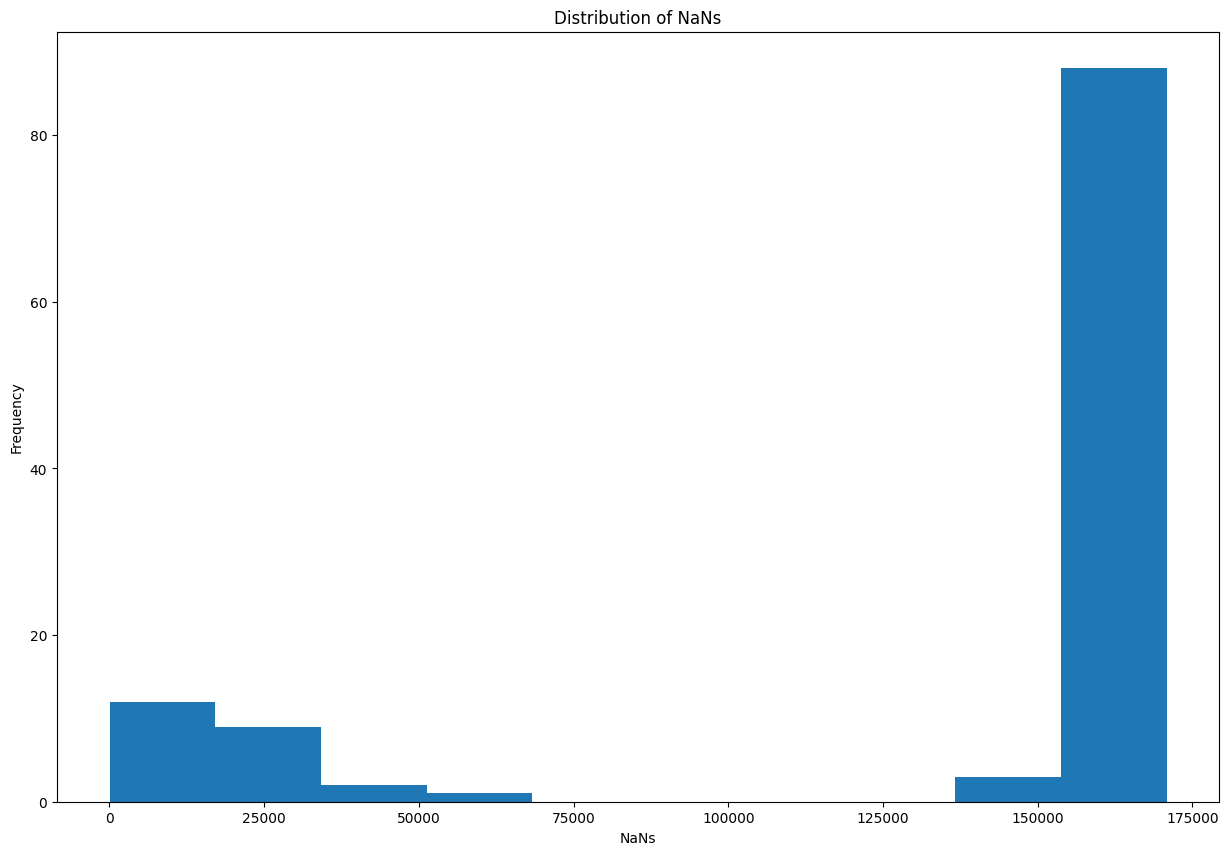

In [ ]:
# Plot NaN values in columns
df_cleaned.isnull().sum().plot(kind='hist', figsize=(15,10))
plt.title('Distribution of NaNs')
plt.xlabel('NaNs')
plt.show()

From the plot, we know that there are many columns that contains less than 20% usable data. We will drop those columns and the NaN only columns.

In [ ]:
# Drop all columns that contain less than 20% usable data
# This also takes care of the columns with all NaNs
df_cleaned = df_cleaned.dropna(axis=1, thresh=int(0.2*len(df_cleaned)), )

print('There are {} rows and {} columns in the cleaned data now.'.format(df_cleaned.shape[0], df_cleaned.shape[1]))

There are 170815 rows and 24 columns in the cleaned data now.


We will also drop rows that contain less than 20% usable data and the NaN only rows.

In [ ]:
# Drop all rows that contain less than 20% usable data
df_cleaned = df_cleaned.dropna(axis=0, thresh=int(0.2*len(df_cleaned.columns)), )

print('There are {} rows and {} columns in the cleaned data now.'.format(df_cleaned.shape[0], df_cleaned.shape[1]))

There are 170707 rows and 24 columns in the cleaned data now.


Since we find organic food by finding key words in columns of product_name and ingredients_text, we drop all rows that contain NaNs in both columns in the same row.

In [ ]:
# Drop all rows that are NaNs in both columns of 'product_name', and 'ingredients_text' since we can not find out whether they are organic
df_cleaned = df_cleaned.dropna(axis=0, subset=['product_name', 'ingredients_text'], how='all')

print('There are {} rows and {} columns in the cleaned data now.'.format(df_cleaned.shape[0], df_cleaned.shape[1]))

There are 170706 rows and 24 columns in the cleaned data now.


In [ ]:
# Check the number of NaNs in each column
df_cleaned.isnull().sum().sort_values()

,0
product_name,48
ingredients_text,85
additives_n,85
additives,90
carbohydrates_100g,388
energy_100g,471
serving_size,515
fat_100g,515
sodium_100g,878
salt_100g,878


In [ ]:
# Check the data with NaN value in 'product_name'
df_cleaned[df_cleaned['product_name'].isna()].sort_values(by='ingredients_text').head()

,product_name,ingredients_text,serving_size,additives_n,additives,additives_en,nutrition_grade_fr,energy_100g,fat_100g,saturated-fat_100g,...,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
code,,,,,,,,,,,,,,,,,,,,,
634418523549,NaN,"*maltitol syrup, water, gelatin, lactic acid, ...",20 g (20 g),10.0,[ maltitol-syrup -> en:e965ii -> exists -- ...,"E102 - Tartrazine,E110 - Sunset yellow FCF,E12...",a,941.0,0.00,0.00,...,0.0,5.00,0.12700,0.050,0.000000,0.0000,0.000,0.00000,-1.0,-1.0
41570089767,NaN,"Almondmilk (filtered water, almonds), coconutm...",240 ml (1 cup),5.0,[ almondmilk -> en:almondmilk ] [ filtered-...,"E170 - Calcium carbonate,E307 - Alpha-tocopher...",b,71.0,1.46,0.42,...,0.4,0.42,0.12700,0.050,0.000062,0.0000,0.188,0.00030,0.0,0.0
12000140525,NaN,"Carbonated water, high fructose corn syrup, ca...",355 ml (12 fl oz),3.0,[ carbonated-water -> en:carbonated-water ] ...,"E150a - Plain caramel,E330 - Citric acid,E338 ...",NaN,176.0,0.00,NaN,...,NaN,0.00,0.02032,0.008,NaN,NaN,NaN,NaN,NaN,NaN
9340224006596,NaN,"Chia seed gel (filtered water, chia seed), str...",170 g (6 ONZ),0.0,[ chia-seed-gel -> en:chia-seed-gel ] [ see...,NaN,a,343.0,5.29,2.94,...,3.5,1.76,0.01524,0.006,0.000000,0.0176,0.047,0.00064,-1.0,-1.0
634418523808,NaN,"Corn syrup (from corn), sugar (from beets), ge...",40 g (12 PIECES | ABOUT),7.0,[ corn-syrup -> en:corn-syrup ] [ syrup -> ...,"E102 - Tartrazine,E110 - Sunset yellow FCF,E12...",d,1255.0,0.00,0.00,...,0.0,5.00,0.06350,0.025,0.000000,0.0000,0.000,0.00000,13.0,13.0


Since we need to operate on string values, we replace the NaNs with 'product name unavailable' in product_name column.

In [ ]:
# Replace the NaNs with 'product name unavailable' in column 'product_name'
df_cleaned['product_name'].fillna(value='product name unavailable', inplace=True)

We can see from the list above, that we are dealing with some inconsistency with the format of columns. Some have hyphens (-).  Let's just replace those hyphens with underscores to stay consistent

In [ ]:
# We rename all columns that contain a "-" since in some scenarios this can cause problems with python 3
columns_with_hyphen = [col for col in df_cleaned.columns if '-' in col]

# Display the columns with hyphen
print("Columns with hyphen:", columns_with_hyphen)

Columns with hyphen: ['saturated-fat_100g', 'trans-fat_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']


In [ ]:
# strip all hyphens and take all leading underscores out if there are any (this case there are none, but previous iteration there were some)
df_cleaned.columns = df_cleaned.columns.str.replace('-', '_').str.lstrip('_')

# Display the updated columns to confirm the change
print("Updated columns:", df_cleaned.columns)

Updated columns: Index(['product_name', 'ingredients_text', 'serving_size', 'additives_n',
       'additives', 'additives_en', 'nutrition_grade_fr', 'energy_100g',
       'fat_100g', 'saturated_fat_100g', 'trans_fat_100g', 'cholesterol_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g', 'vitamin_a_100g', 'vitamin_c_100g',
       'calcium_100g', 'iron_100g', 'nutrition_score_fr_100g',
       'nutrition_score_uk_100g'],
      dtype='object')


**Clean Duplicates**

In [ ]:
# Find number of duplicated rows
df_cleaned.duplicated().sum()

6170

In [ ]:
# Check the duplicated rows
df_cleaned[df_cleaned.duplicated(keep=False)].sort_values(by=['product_name', 'ingredients_text']).head()

,product_name,ingredients_text,serving_size,additives_n,additives,additives_en,nutrition_grade_fr,energy_100g,fat_100g,saturated_fat_100g,...,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin_a_100g,vitamin_c_100g,calcium_100g,iron_100g,nutrition_score_fr_100g,nutrition_score_uk_100g
code,,,,,,,,,,,,,,,,,,,,,
631656560534,1 Clean Protein Bar,"Protein blend (milk protein isolate, whey prot...",60 g (1 BAR),0.0,[ protein-blend -> en:protein-blend ] [ ble...,NaN,c,1393.0,11.67,4.17,...,28.3,35.00,0.76200,0.300,0.000000,0.0000,0.167,0.00060,6.0,6.0
631656560541,1 Clean Protein Bar,"Protein blend (milk protein isolate, whey prot...",60 g (1 BAR),0.0,[ protein-blend -> en:protein-blend ] [ ble...,NaN,c,1393.0,11.67,4.17,...,28.3,35.00,0.76200,0.300,0.000000,0.0000,0.167,0.00060,6.0,6.0
41497097548,"1% Low Fat Chocolate Milk, Chocolate","Low fat milk, high fructose corn syrup, sugar,...",240 ml (1 cup),1.0,[ low-fat-milk -> en:low-fat-milk ] [ fat-m...,E407 - Carrageenan,b,259.0,1.04,0.62,...,0.0,3.33,0.19050,0.075,0.000050,0.0000,0.125,0.00015,0.0,0.0
41497097555,"1% Low Fat Chocolate Milk, Chocolate","Low fat milk, high fructose corn syrup, sugar,...",240 ml (1 cup),1.0,[ low-fat-milk -> en:low-fat-milk ] [ fat-m...,E407 - Carrageenan,b,259.0,1.04,0.62,...,0.0,3.33,0.19050,0.075,0.000050,0.0000,0.125,0.00015,0.0,0.0
70852000145,1% Low Fat Milk,"Certified organic grade a low fat milk, certif...",240 ml (1 cup),0.0,[ certified-organic-grade-a-low-fat-milk -> e...,NaN,a,209.0,1.04,0.62,...,0.0,4.58,0.17018,0.067,0.000062,0.0005,0.167,0.00000,-1.0,-1.0


In [ ]:
# Keep the first row of each duplicates and drop the rest
df_cleaned.drop_duplicates(keep='first', inplace=True)

print('There are {} rows and {} columns in the cleaned data now.'.format(df_cleaned.shape[0], df_cleaned.shape[1]))

There are 164536 rows and 24 columns in the cleaned data now.


**Label Organic Food**

To be labeled as "organic" by the USDA, a product must contain at least 95% certified organic ingredients, excluding salt and water; if a product contains less than 70% organic ingredients, it can only list specific organic ingredients on the label and cannot use the USDA organic seal.

We consider the food as organic if the product_name contains key word 'organic' and the ingredients_text contains key word 'organic' or 'org' (since some rows list the organic ingredients as 'org xxx')

In [ ]:
# To be labeled as "organic" by the USDA, a product must contain at least 95% certified organic ingredients, excluding salt and water; if a product contains less than 70% organic ingredients, it can only list specific organic ingredients on the label and cannot use the USDA organic seal.

# We consider the food as organic if the product_name contains key word 'organic' and the ingredients_text contains key word 'organic' or 'org' (since some rows list the organic ingredients as 'org xxx')

# Label for 'organic' in product_name
df_cleaned['organic_label_name'] = df_cleaned['product_name'].apply(lambda x: 1 if 'organic' in str(x).lower() else 0)
# Label for 'org' in ingredients_text
df_cleaned['organic_label_ingredients_org'] = df_cleaned['ingredients_text'].apply(lambda x: 1 if 'org' in str(x).lower() else 0)
# Combine the Labels
df_cleaned['organic_label_combine'] = df_cleaned['organic_label_name'] + df_cleaned['organic_label_ingredients_org']
df_cleaned['organic_label'] = df_cleaned['organic_label_combine'].apply(lambda x: 1 if x > 0 else 0)

df_cleaned.drop(columns=['organic_label_name', 'organic_label_ingredients_org', 'organic_label_combine'], inplace=True)

In [ ]:
print('There are {} rows of non-organic food data'.format(df_cleaned['organic_label'].value_counts()[0])+'\nThere are {} rows of organic food data'.format(df_cleaned['organic_label'].value_counts()[1]))

There are 144190 rows of non-organic food data
There are 20346 rows of organic food data


**Dealing with Erroneous Data**

In [ ]:
# Check the statistics of data
df_cleaned.describe()

,additives_n,energy_100g,fat_100g,saturated_fat_100g,trans_fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin_a_100g,vitamin_c_100g,calcium_100g,iron_100g,nutrition_score_fr_100g,nutrition_score_uk_100g,organic_label
count,164451.000000,164067.000000,164023.000000,139728.000000,136450.000000,137155.000000,164151.000000,154074.000000,134821.000000,163574.000000,163667.000000,163667.000000,130957.000000,133286.000000,132037.000000,133141.000000,134079.000000,134079.000000,164536.000000
mean,2.077938,1133.250588,12.229129,4.915204,0.074383,0.020231,34.047958,17.229467,2.941941,6.871771,2.458032,0.967729,0.000155,0.022195,0.121997,0.003158,9.532343,9.519045,0.123657
std,2.573214,1007.204150,16.974319,7.693420,1.571245,0.365722,30.479877,23.684949,15.394587,8.694575,160.197824,63.070009,0.000712,2.275037,3.416579,0.200541,8.988009,8.994960,0.329191
min,0.000000,0.000000,0.000000,0.000000,-3.570000,0.000000,0.000000,-17.860000,-6.700000,-800.000000,0.000000,0.000000,-0.000340,-0.002100,0.000000,-0.000260,-13.000000,-13.000000,0.000000
25%,0.000000,368.000000,0.000000,0.000000,0.000000,0.000000,6.670000,1.670000,0.000000,0.000000,0.063500,0.025000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
50%,1.000000,1155.000000,4.420000,1.790000,0.000000,0.000000,24.290000,6.760000,1.500000,4.080000,0.635000,0.250000,0.000000,0.000000,0.035000,0.001000,10.000000,10.000000,0.000000
75%,3.000000,1674.000000,20.000000,7.140000,0.000000,0.021000,60.710000,26.470000,3.600000,10.000000,1.480820,0.583000,0.000107,0.003200,0.100000,0.002400,17.000000,17.000000,0.000000
max,30.000000,231199.000000,100.000000,550.000000,369.000000,95.238000,2916.670000,3520.000000,5380.000000,430.000000,64312.800000,25320.000000,0.051818,716.981100,694.737000,50.000000,40.000000,40.000000,1.000000


We can look at the minimums and maximums and see that there is erroneous data.


*   The amount of nutrient_100g under fields should be in range \[0,100\] except for the energy and nutrition-score.
*   Fields such as iron_100g, vitamin_c_100g, calcium_100g, vitamin_a_100g are normally in milligram level or lower.
*   Since total carbohydrates include sugars and fiber, sugars_100g, fiber_100g and their sum should all be less than carbohydrates_100g.
*   Since total fat includes saturated fat and trans fat, saturated_fat_100g, trans_fat_100g and their sum should all be less than fat_100g.
*   To reach the maximum energy per 100g, the food should be pure fat since fat is the most energy-dense nutrient. 100g fat contains about 4000 kJ energy, which is the cap of energy_100g.
*   The sum of the total nutritions (exludes energy) per 100g should be less than 100g.
*   nutrition-score-fr_100g and nutrition-score-uk_100g both range from -15 to 40. From the data description, we can see both of them are in range.

In [ ]:
print('There are {} rows and {} columns in the cleaned data now.'.format(df_cleaned.shape[0], df_cleaned.shape[1]))

There are 164536 rows and 25 columns in the cleaned data now.


In [ ]:
nutrition_columns = ['fat_100g',
                      'saturated_fat_100g',
                      'trans_fat_100g',
                      'cholesterol_100g',
                      'carbohydrates_100g',
                      'sugars_100g',
                      'fiber_100g',
                      'proteins_100g',
                      'salt_100g',
                      'sodium_100g',
                      'vitamin_a_100g',
                      'vitamin_c_100g',
                      'calcium_100g',
                      'iron_100g']

In [ ]:
# The amount of nutrients under fields should be in the range [0,100].

df_cleaned = df_cleaned[(df_cleaned[nutrition_columns] <= 100).all(1)]
df_cleaned = df_cleaned[(df_cleaned[nutrition_columns] >= 0).all(1)]

print('There are {} rows and {} columns in the cleaned data now.'.format(df_cleaned.shape[0], df_cleaned.shape[1]))

There are 120995 rows and 25 columns in the cleaned data now.


In [ ]:
# Columns of nutrients with milligram level amount
milligram_columns = ['vitamin_a_100g',
                     'vitamin_c_100g',
                     'calcium_100g',
                     'iron_100g']

In [ ]:
# Fields such as iron_100g, vitamin_c_100g, calcium_100g, vitamin_a_100g are normally in milligram level or lower. Set 5g as the cap.

df_cleaned = df_cleaned[(df_cleaned[milligram_columns] < 5).all(1)]

print('There are {} rows and {} columns in the cleaned data now.'.format(df_cleaned.shape[0], df_cleaned.shape[1]))

There are 120982 rows and 25 columns in the cleaned data now.


In [ ]:
# Since total carbohydrates include sugars and fiber, sugars_100g, fiber_100g and their sum should all be less than carbohydrates_100g.

df_cleaned = df_cleaned[df_cleaned['carbohydrates_100g'] >= df_cleaned['sugars_100g']]
df_cleaned = df_cleaned[df_cleaned['carbohydrates_100g'] >= df_cleaned['fiber_100g']]
df_cleaned = df_cleaned[df_cleaned['carbohydrates_100g'] >= (df_cleaned['sugars_100g'] + df_cleaned['fiber_100g'])]

print('There are {} rows and {} columns in the cleaned data now.'.format(df_cleaned.shape[0], df_cleaned.shape[1]))

There are 116662 rows and 25 columns in the cleaned data now.


In [ ]:
# Since total fat includes saturated fat and trans fat, saturated_fat_100g, trans_fat_100g and their sum should all be less than fat_100g
# cholesterol_100g should be less than fat_100g

df_cleaned = df_cleaned[df_cleaned['fat_100g'] >= df_cleaned['cholesterol_100g']]
df_cleaned = df_cleaned[df_cleaned['fat_100g'] >= df_cleaned['saturated_fat_100g']]
df_cleaned = df_cleaned[df_cleaned['fat_100g'] >= df_cleaned['trans_fat_100g']]
df_cleaned = df_cleaned[df_cleaned['fat_100g'] >= (df_cleaned['saturated_fat_100g'] + df_cleaned['trans_fat_100g'])]

print('There are {} rows and {} columns in the cleaned data now.'.format(df_cleaned.shape[0], df_cleaned.shape[1]))

There are 115008 rows and 25 columns in the cleaned data now.


In [ ]:
# Maximum amount of energy_100g is about 4000kJ when the food is 100g pure fat.
df_cleaned = df_cleaned[df_cleaned['energy_100g'] <= 4000]

print('There are {} rows and {} columns in the cleaned data now.'.format(df_cleaned.shape[0], df_cleaned.shape[1]))

There are 114953 rows and 25 columns in the cleaned data now.


In [ ]:
nutrition_total_columns = ['fat_100g',
                            'carbohydrates_100g',
                            'proteins_100g',
                            'salt_100g']

In [ ]:
# The sum of the total nutritions (exludes energy) per 100g should be less than 100g
# sugars_100g and fiber_100g included in carbohydrates_100g.
# saturated_fat_100g, trans_fat_100g and cholesterol_100g are included in fat_100g
# Since sodium, vitamins, calcium and iron are in milligram level, we will ignore them.

df_cleaned = df_cleaned[(df_cleaned[nutrition_total_columns].sum(axis=1) <= 100)]

print('There are {} rows and {} columns in the cleaned data now.'.format(df_cleaned.shape[0], df_cleaned.shape[1]))

There are 111823 rows and 25 columns in the cleaned data now.


**nutrition_score_fr_100g vs. nutrition_score_uk_100g**

Nutrition score derived from the UK FSA score and adapted for the French market.

Let's first visualize the difference between them

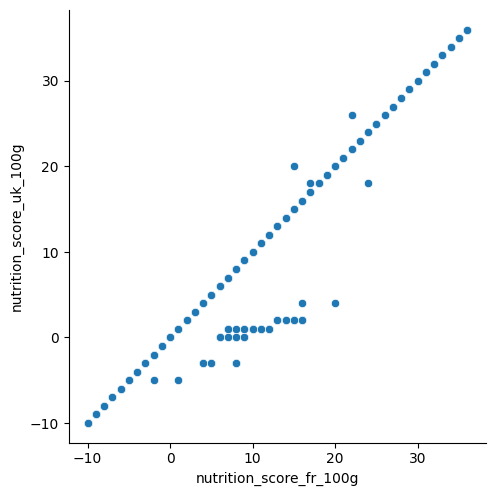

In [ ]:
df_cleaned = df_cleaned.reset_index(drop=True) # need to reset index for composition of graph
sns.pairplot(df_cleaned, x_vars=['nutrition_score_fr_100g'], y_vars=['nutrition_score_uk_100g'], height=5)

plt.show()

Both France and the UK use a system based on the same underlying nutrient profiling system (developed by the UK Food Standards Agency), most foods share the same score in both as we can tell from the plot. To make the data simpler, we will ignore the food that has different scores and only keep one field as nutrition_score_100g

In [ ]:
# Only keep rows that have the same nutrition score
df_cleaned = df_cleaned[df_cleaned['nutrition_score_fr_100g'] == df_cleaned['nutrition_score_uk_100g']]
# Keep one field as nutrition_score_100g
df_cleaned['nutrition_score_100g'] = df_cleaned['nutrition_score_fr_100g']
df_cleaned.drop(columns=['nutrition_score_fr_100g', 'nutrition_score_uk_100g'], inplace=True)

print('There are {} rows and {} columns in the cleaned data now.'.format(df_cleaned.shape[0], df_cleaned.shape[1]))

There are 111713 rows and 24 columns in the cleaned data now.


<ipython-input-47-021028503884>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['nutrition_score_100g'] = df_cleaned['nutrition_score_fr_100g']
<ipython-input-47-021028503884>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.drop(columns=['nutrition_score_fr_100g', 'nutrition_score_uk_100g'], inplace=True)


**nutrition_grade_fr**

The field nutrition_grade_fr is a French nutrition label that has five level scale and letters from A to E. letter A means higher nutrition quality and E means lower nutrition quality. We map these letters to numbers from 5 to 1.

In [ ]:
# We map the letters from a to e to numbers from 5 to 1
nutr_map = {'a':5, 'b':4, 'c':3, 'd':2, 'e':1}
df_cleaned['nutrition_grade'] = df_cleaned['nutrition_grade_fr'].map(nutr_map)
df_cleaned['nutrition_grade'].head()

,nutrition_grade
0,2
1,4
2,3
3,2
4,3


**Dealing with Outliers**

A good rule of thumb is to get rid of data that is more than 3 standard deviations away from the mean.


In [ ]:
columns_to_check = ['additives_n',
                    'energy_100g',
                    'fat_100g',
                    'saturated_fat_100g',
                    'trans_fat_100g',
                    'cholesterol_100g',
                    'carbohydrates_100g',
                    'sugars_100g',
                    'fiber_100g',
                    'proteins_100g',
                    'salt_100g',
                    'sodium_100g',
                    'vitamin_a_100g',
                    'vitamin_c_100g',
                    'calcium_100g',
                    'iron_100g',
                    'nutrition_score_100g']

In [ ]:
# get rid of data that is more than 3 standard deviations from the mean
for col in columns_to_check:
    df_cleaned = df_cleaned[np.abs(df_cleaned[col] - df_cleaned[col].mean()) <= (3 * df_cleaned[col].std())]

In [ ]:
print("We now have {:,} rows in our dataset".format(df_cleaned.shape[0]))

We now have 91,466 rows in our dataset


In [ ]:
# Check the statistics
df_cleaned.describe()

,additives_n,energy_100g,fat_100g,saturated_fat_100g,trans_fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin_a_100g,vitamin_c_100g,calcium_100g,iron_100g,organic_label,nutrition_score_100g,nutrition_grade
count,91466.000000,91466.000000,91466.000000,91466.000000,91466.000000,91466.000000,91466.000000,91466.000000,91466.000000,91466.000000,91466.000000,91466.000000,91466.000000,91466.000000,91466.000000,91466.000000,91466.000000,91466.000000,91466.000000
mean,1.975018,1152.139877,12.002236,3.831783,0.007423,0.013446,35.842166,14.704144,2.527946,6.910677,0.897545,0.353364,0.000073,0.003625,0.059957,0.001463,0.124964,8.562985,2.904631
std,2.160366,711.637337,13.292913,4.997969,0.081842,0.023832,26.944888,17.580254,3.043273,6.287701,0.879944,0.346435,0.000164,0.009522,0.085949,0.001693,0.330680,8.752915,1.317921
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-10.000000,1.000000
25%,0.000000,456.000000,1.070000,0.000000,0.000000,0.000000,10.710000,1.890000,0.000000,2.380000,0.152400,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
50%,1.000000,1151.000000,7.140000,1.750000,0.000000,0.000000,29.170000,6.250000,1.600000,5.260000,0.726440,0.286000,0.000000,0.000000,0.031000,0.001060,0.000000,9.000000,3.000000
75%,3.000000,1715.000000,20.000000,6.250000,0.000000,0.017000,60.610000,23.530000,3.600000,10.000000,1.305560,0.514000,0.000088,0.002100,0.088000,0.002320,0.000000,15.000000,4.000000
max,10.000000,3289.000000,57.140000,22.860000,1.590000,0.119000,100.000000,72.730000,15.300000,31.250000,4.572000,1.800000,0.001483,0.086400,0.588000,0.014520,1.000000,34.000000,5.000000


**Data Distribution by Fields**

Check the data distribution in each numericle data fields with plot.

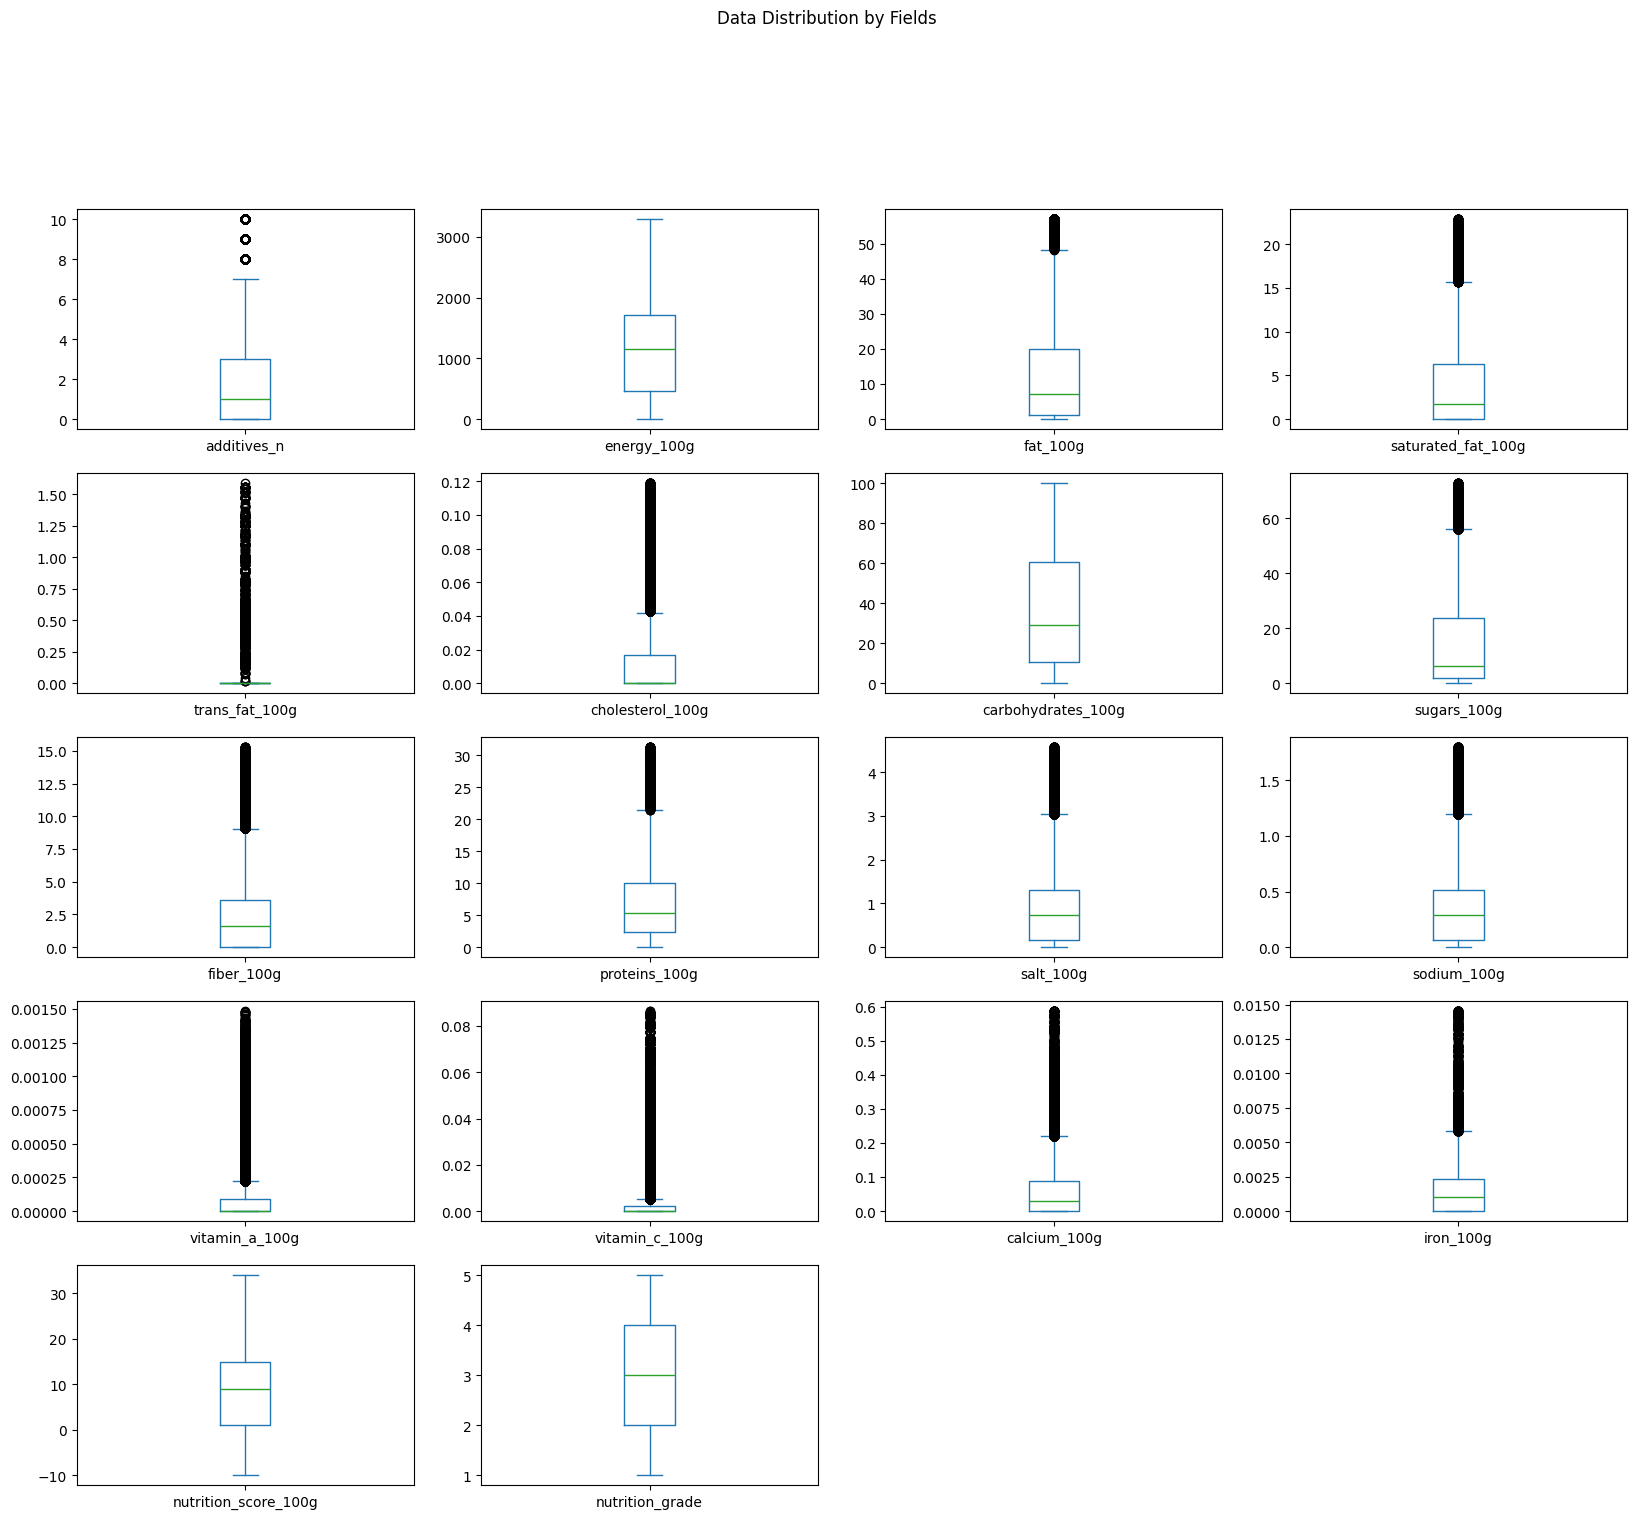

In [ ]:
# Visualize the distribution by boxplot
df_to_plot = df_cleaned.select_dtypes(include=[float, int]).drop(columns=['organic_label'])
df_to_plot.plot(kind='box', subplots=True, title='Data Distribution by Fields', figsize=(20,20), layout=(6,4))

plt.show()

**Understanding the Plots:**

Median:
* The horizontal line inside the box represents the median (50th percentile) of the data.

Quartiles:
* The bottom of the box indicates the first quartile (25th percentile).
* The top of the box indicates the third quartile (75th percentile).

Interquartile Range (IQR):
* The height of the box represents the IQR (the middle 50% of the data).

Whiskers:
* The lines extending from the box (whiskers) typically represent the range of the data within 1.5 times the IQR from the quartiles.

Outliers:
* Points outside the whiskers are considered outliers and are typically shown as individual points.

Analyzing the Box Plots
* *Skewness:* If the median line is closer to the bottom or top of the box, it indicates skewness. For example, if the median is closer to the bottom, the data might be right-skewed.

* *Outliers:* Points outside the whiskers show outliers. A high number of outliers suggests a significant amount of variability or anomalies in the data.

* *Spread:* The IQR (box height) indicates the spread of the middle 50% of the data. A larger IQR indicates more variability in the data.

* *Comparison:* Comparing boxes across different plots can highlight differences in the distribution, spread, and presence of outliers for each feature.

May not be pretty and ideal, but we did get rid of all the outliers 3 standard deviations away from mean


**additives**

The data in additives column contain similar ingredients as in the ingredients_text column. However, it contains all kinds of format symbols like -> en:*. We will remove those.

In [ ]:
#Peek
df_cleaned.head()

,product_name,ingredients_text,serving_size,additives_n,additives,additives_en,nutrition_grade_fr,energy_100g,fat_100g,saturated_fat_100g,...,proteins_100g,salt_100g,sodium_100g,vitamin_a_100g,vitamin_c_100g,calcium_100g,iron_100g,organic_label,nutrition_score_100g,nutrition_grade
1,Peanuts,"Peanuts, wheat flour, sugar, rice flour, tapio...",28 g (0.25 cup),0.0,[ peanuts -> en:peanuts ] [ wheat-flour -> ...,NaN,b,1941.0,17.86,0.00,...,17.86,0.63500,0.250,0.000000,0.0,0.071,0.00129,0,0.0,4
2,Granola Cranberry And Acai,"Whole rolled oats, milled cane sugar, vegetabl...",55 g (0.5 cup),0.0,[ whole-rolled-oats -> en:whole-rolled-oats ...,NaN,c,1824.0,10.91,0.91,...,9.09,0.25400,0.100,0.000000,0.0,0.036,0.00262,0,6.0,3
3,"Peanuts, Mixed Nuts","Peanuts, honey, coating (sucrose, wheat starch...",28 g (0.25 cup),1.0,[ peanuts -> en:peanuts ] [ honey -> en:hon...,E415 - Xanthan gum,d,2389.0,42.86,7.14,...,25.00,0.54356,0.214,0.000000,0.0,0.071,0.00514,0,14.0,2
4,Cranberries,"Cranberries, sugar, sunflower oil.",30 g (0.25 cup),0.0,[ cranberries -> en:cranberries ] [ sugar -...,NaN,c,1255.0,0.00,0.00,...,0.00,0.00000,0.000,0.000000,0.0,0.000,0.00000,0,8.0,3
5,Turkish Apricots,"Apricots, sulfur dioxide.",40 g (7 PIECES),1.0,[ apricots -> en:apricots ] [ sulfur-dioxid...,E220 - Sulphur dioxide,c,1046.0,0.00,0.00,...,2.50,0.00000,0.000,0.001125,0.0,0.050,0.00360,0,8.0,3


In [ ]:
import re

# Function to clean the additives column
def clean_additives(additives):
    if isinstance(additives, str):
        return re.sub(r'-> en:[^\]]*', '', additives).strip()
    return additives

# Apply the cleaning function to the column
df_cleaned['additives'] = df_cleaned['additives'].apply(clean_additives)

# Display the cleaned DataFrame
print(df_cleaned['additives'])


1         [ peanuts ]  [ wheat-flour ]  [ flour ]  [ sug...
2         [ whole-rolled-oats ]  [ rolled-oats ]  [ oats...
3         [ peanuts ]  [ honey ]  [ coating ]  [ sucrose...
4         [ cranberries ]  [ sugar ]  [ sunflower-oil ] ...
5                          [ apricots ]  [ sulfur-dioxide ]
                                ...                        
111818    [ wheat-flour ]  [ flour ]  [ sugar ]  [ veget...
111819    [ tomato ]  [ black-gram ]  [ gram ]  [ water ...
111820    [ organic-oat-blend ]  [ oat-blend ]  [ blend ...
111821                                          [ cassava ]
111822    [ organic-peppermint ]  [ peppermint ]  [ orga...
Name: additives, Length: 91466, dtype: object


We got rid of all the -> en:* 's. We will keep the format as it is for now since we may not want to do EDA or NLP on this particular column. We can do some quick wrangling in the beginning of that notebook/section to get data up to date.

**serving_size**

Do we want to get rid of serving_size now?  We will see about it later.


In [ ]:
# Check the unique values in 'serving_size'
df_cleaned['serving_size'].unique()

array(['28 g (0.25 cup)', '55 g (0.5 cup)', '30 g (0.25 cup)', ...,
       '18.5 g (2.6 oz)', '12.5 g (0.45 oz)', '22 g (3 PCS)'],
      dtype=object)

**Final Clean and Check**

In [ ]:
# Reset index
df_cleaned.reset_index(drop=True, inplace=True)

In [ ]:
# Peek
df_cleaned.head()

,product_name,ingredients_text,serving_size,additives_n,additives,additives_en,nutrition_grade_fr,energy_100g,fat_100g,saturated_fat_100g,...,proteins_100g,salt_100g,sodium_100g,vitamin_a_100g,vitamin_c_100g,calcium_100g,iron_100g,organic_label,nutrition_score_100g,nutrition_grade
0,Peanuts,"Peanuts, wheat flour, sugar, rice flour, tapio...",28 g (0.25 cup),0.0,[ peanuts ] [ wheat-flour ] [ flour ] [ sug...,NaN,b,1941.0,17.86,0.00,...,17.86,0.63500,0.250,0.000000,0.0,0.071,0.00129,0,0.0,4
1,Granola Cranberry And Acai,"Whole rolled oats, milled cane sugar, vegetabl...",55 g (0.5 cup),0.0,[ whole-rolled-oats ] [ rolled-oats ] [ oats...,NaN,c,1824.0,10.91,0.91,...,9.09,0.25400,0.100,0.000000,0.0,0.036,0.00262,0,6.0,3
2,"Peanuts, Mixed Nuts","Peanuts, honey, coating (sucrose, wheat starch...",28 g (0.25 cup),1.0,[ peanuts ] [ honey ] [ coating ] [ sucrose...,E415 - Xanthan gum,d,2389.0,42.86,7.14,...,25.00,0.54356,0.214,0.000000,0.0,0.071,0.00514,0,14.0,2
3,Cranberries,"Cranberries, sugar, sunflower oil.",30 g (0.25 cup),0.0,[ cranberries ] [ sugar ] [ sunflower-oil ] ...,NaN,c,1255.0,0.00,0.00,...,0.00,0.00000,0.000,0.000000,0.0,0.000,0.00000,0,8.0,3
4,Turkish Apricots,"Apricots, sulfur dioxide.",40 g (7 PIECES),1.0,[ apricots ] [ sulfur-dioxide ],E220 - Sulphur dioxide,c,1046.0,0.00,0.00,...,2.50,0.00000,0.000,0.001125,0.0,0.050,0.00360,0,8.0,3


In [ ]:
# Check data info
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91466 entries, 0 to 91465
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   product_name          91466 non-null  object 
 1   ingredients_text      91466 non-null  object 
 2   serving_size          91466 non-null  object 
 3   additives_n           91466 non-null  float64
 4   additives             91461 non-null  object 
 5   additives_en          62159 non-null  object 
 6   nutrition_grade_fr    91466 non-null  object 
 7   energy_100g           91466 non-null  float64
 8   fat_100g              91466 non-null  float64
 9   saturated_fat_100g    91466 non-null  float64
 10  trans_fat_100g        91466 non-null  float64
 11  cholesterol_100g      91466 non-null  float64
 12  carbohydrates_100g    91466 non-null  float64
 13  sugars_100g           91466 non-null  float64
 14  fiber_100g            91466 non-null  float64
 15  proteins_100g      

In [ ]:
# Check the number of NaNs in each column
df_cleaned.isnull().sum().sort_values()

,0
product_name,0
organic_label,0
iron_100g,0
calcium_100g,0
vitamin_c_100g,0
vitamin_a_100g,0
sodium_100g,0
salt_100g,0
proteins_100g,0
fiber_100g,0


In [ ]:
print('There are {} rows of non-organic food data'.format(df_cleaned['organic_label'].value_counts()[0])+'\nThere are {} rows of organic food data'.format(df_cleaned['organic_label'].value_counts()[1]))

There are 80036 rows of non-organic food data
There are 11430 rows of organic food data


In [ ]:
# Save the cleaned data to a csv file
#df_cleaned.to_csv('cleaned_data_DW_z_score.csv', index=False)